In [18]:
## libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import os, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt

In [14]:
## dataset
def load_cifar10(path):
    data, labels = [], []
    for i in range(1, 6):
        with open(os.path.join(path, f"data_batch_{i}"), 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
            data.append(batch[b'data'])
            labels += batch[b'labels']
    X = np.concatenate(data).astype(np.float32) / 255.0
    y = np.array(labels).reshape(-1, 1)
    return X, y

def load_cifar10_test(path):
    with open(os.path.join(path, "test_batch"), 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        X = batch[b'data'].astype(np.float32) / 255.0
        y = np.array(batch[b'labels']).reshape(-1, 1)
    return X, y

In [15]:
class ANN_r:
    def __init__(self, input_dim, hidden_layers, output_dim, lr=0.1):
        self.lr = lr
        self.layers = []
        prev = input_dim
        for h in hidden_layers:
            self.layers.append({
                "W": np.random.randn(prev, h) * np.sqrt(2.0 / prev),  # He init for ReLU
                "b": np.zeros((1, h))
            })
            prev = h
        self.out = {
            "W": np.random.randn(prev, output_dim) * 0.01,
            "b": np.zeros((1, output_dim))
        }

    # ReLU activation and derivative
    def relu(self, z):
        return np.maximum(0, z)

    def relu_deriv(self, z):
        return (z > 0).astype(float)

    def softmax(self, z):
        z -= np.max(z, axis=1, keepdims=True)
        exp = np.exp(z)
        return exp / np.sum(exp, axis=1, keepdims=True)

    def forward(self, X):
        self.cache = [{'a': X}]
        a = X
        for layer in self.layers:
            z = a @ layer['W'] + layer['b']
            a = self.relu(z)
            self.cache.append({'a': a, 'z': z})
        z_out = a @ self.out['W'] + self.out['b']
        a_out = self.softmax(z_out)
        self.cache.append({'a': a_out, 'z': z_out})
        return a_out

    def backward(self, X, Y, out):
        m = X.shape[0]
        dz = (out - Y) / m

        # output layer update
        a_prev = self.cache[-2]['a']
        dW = a_prev.T @ dz
        db = np.sum(dz, axis=0, keepdims=True)
        self.out['W'] -= self.lr * dW
        self.out['b'] -= self.lr * db
        da = dz @ self.out['W'].T

        # hidden layers backward
        for i in reversed(range(len(self.layers))):
            z_curr = self.cache[i+1]['z']
            a_prev = self.cache[i]['a']
            dz = da * self.relu_deriv(z_curr)
            dW = a_prev.T @ dz
            db = np.sum(dz, axis=0, keepdims=True)
            self.layers[i]['W'] -= self.lr * dW
            self.layers[i]['b'] -= self.lr * db
            da = dz @ self.layers[i]['W'].T

    def loss(self, Y, out):
        return -np.mean(np.sum(Y * np.log(out + 1e-9), axis=1))

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)


In [21]:
def train_model_r(X_train, Y_train, X_test, Y_test, layers, name, epochs=10, lr=0.1):
    model = ANN_r(3072, layers, 10, lr)
    best_acc = 0
    losses=[]
    accs=[]
    for epoch in range(epochs):
        out = model.forward(X_train)
        loss = model.loss(Y_train, out)
        losses.append(loss)
        model.backward(X_train, Y_train, out)
        preds = model.predict(X_test)
        
        acc = accuracy_score(np.argmax(Y_test, axis=1), preds)
        accs.append(acc)
        print(f"{name} | Epoch {epoch+1}/{epochs} | Loss={loss:.4f} | Acc={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            np.savez(f"{name}_best_weights.npz",
                     layers=model.layers, out=model.out)
    print(f"Best accuracy for {name}: {best_acc:.4f}")
    return losses, accs



In [22]:
X_train, y_train = load_cifar10("cifar")
X_test, y_test = load_cifar10_test("cifar")
enc = OneHotEncoder(sparse_output=False)
Y_train = enc.fit_transform(y_train)
Y_test = enc.transform(y_test)

In [23]:
losses,accs=train_model_r(X_train, Y_train, X_test, Y_test, [100], "model_1layer", epochs=10, lr=0.1)

model_1layer | Epoch 1/10 | Loss=2.3060 | Acc=0.0941
model_1layer | Epoch 2/10 | Loss=2.2999 | Acc=0.1151
model_1layer | Epoch 3/10 | Loss=2.2954 | Acc=0.1054
model_1layer | Epoch 4/10 | Loss=2.2914 | Acc=0.1040
model_1layer | Epoch 5/10 | Loss=2.2878 | Acc=0.1043
model_1layer | Epoch 6/10 | Loss=2.2840 | Acc=0.1070
model_1layer | Epoch 7/10 | Loss=2.2802 | Acc=0.1113
model_1layer | Epoch 8/10 | Loss=2.2762 | Acc=0.1178
model_1layer | Epoch 9/10 | Loss=2.2718 | Acc=0.1278
model_1layer | Epoch 10/10 | Loss=2.2671 | Acc=0.1402
Best accuracy for model_1layer: 0.1402


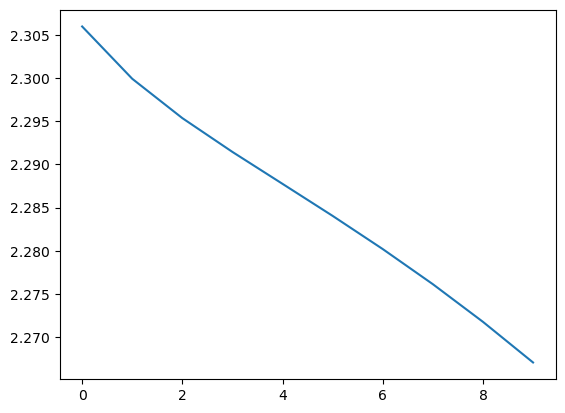

In [26]:
plt.plot(losses)

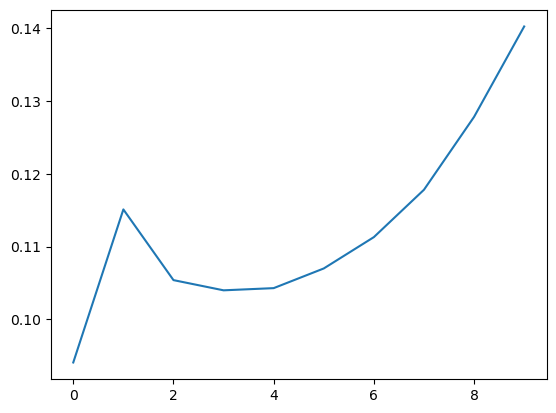

In [27]:
plt.plot(accs)

In [28]:
losses,accs=train_model_r(X_train, Y_train, X_test, Y_test, [100, 50, 50], "model_3layer", epochs=10, lr=0.01)

model_3layer | Epoch 1/10 | Loss=2.3021 | Acc=0.1083
model_3layer | Epoch 2/10 | Loss=2.3019 | Acc=0.1095
model_3layer | Epoch 3/10 | Loss=2.3018 | Acc=0.1098
model_3layer | Epoch 4/10 | Loss=2.3016 | Acc=0.1095
model_3layer | Epoch 5/10 | Loss=2.3014 | Acc=0.1103
model_3layer | Epoch 6/10 | Loss=2.3012 | Acc=0.1105
model_3layer | Epoch 7/10 | Loss=2.3010 | Acc=0.1103
model_3layer | Epoch 8/10 | Loss=2.3009 | Acc=0.1109
model_3layer | Epoch 9/10 | Loss=2.3007 | Acc=0.1104
model_3layer | Epoch 10/10 | Loss=2.3005 | Acc=0.1105
Best accuracy for model_3layer: 0.1109


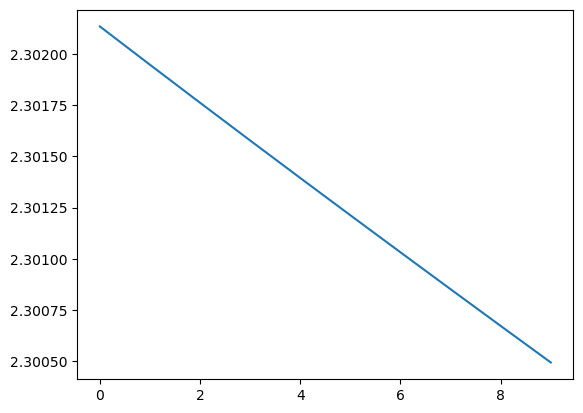

In [29]:
plt.plot(losses)

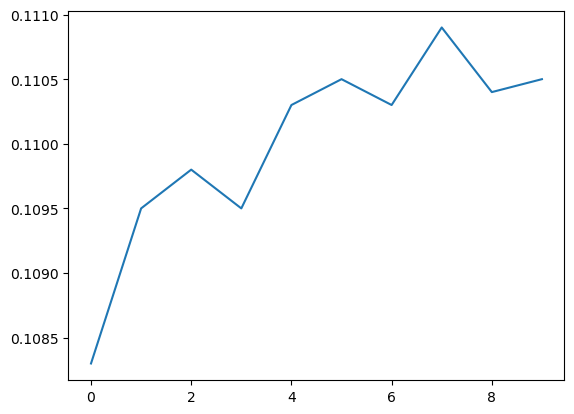

In [30]:
plt.plot(accs)

In [31]:
def diagnose_model(model, X_train, Y_train, X_val, Y_val):
    # Forward passes
    out_train = model.forward(X_train)
    out_val = model.forward(X_val)

    # Compute losses
    train_loss = model.loss(Y_train, out_train)
    val_loss = model.loss(Y_val, out_val)

    # Compute accuracies
    train_pred = np.argmax(out_train, axis=1)
    val_pred = np.argmax(out_val, axis=1)
    y_train_true = np.argmax(Y_train, axis=1)
    y_val_true = np.argmax(Y_val, axis=1)

    train_acc = np.mean(train_pred == y_train_true)
    val_acc = np.mean(val_pred == y_val_true)

    print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
    print(f"Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}")

    # Diagnose
    if train_acc > 0.9 and val_acc < 0.7:
        print("Diagnosis: Overfitting")
    elif train_acc < 0.7 and val_acc < 0.7:
        print("Diagnosis: Underfitting")
    else:
        print("Diagnosis: Good fit")

# Example usage after training
diagnose_model(model_r, X_train, Y_train, X_test, Y_test)

Train loss: 2.2710, Val loss: 2.2711
Train acc: 0.1439, Val acc: 0.1411
Diagnosis: Underfitting
